# Common link
* [Load Data](#load-data)
* [Split Data](#split-dataset)
* [Model](#model)
* [Evaluation](#evaluation)

In [1]:
feature = 29

# Model

In [2]:
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras.backend as K

In [3]:
ae = None
d = None
RAT = 115

In [4]:
def Autoencoder():
    input_layer = layers.Input(name='input', shape=(feature))
    #x = layers.Reshape((height, width, channels), name='ge_reshape')(input_layer)

    # Encoder
    x = layers.Dense(25, name='e_dense_1')(input_layer)
    x = layers.ReLU(name='e_relu_1')(x)

    x = layers.Dense(20, name='e_dense_2')(x)
    x = layers.ReLU(name='e_relu_2')(x)

    x = layers.Dense(15, name='e_dense_3')(x)
    x = layers.ReLU(name='e_relu_3')(x)

    x = layers.Dense(10, name='e_dense_4')(x)
    x = layers.ReLU(name='e_relu_4')(x)

    #decoder
    y = layers.Dense(15, name='dec_dense_1')(x)
    y = layers.ReLU(name='dec_relu_1')(y)

    y = layers.Dense(20, name='dec_dense_2')(y)
    y = layers.ReLU(name='dec_relu_2')(y)

    y = layers.Dense(25, name='dec_dense_3')(y)
    y = layers.ReLU(name='dec_relu_3')(y)

    y = layers.Dense(feature, name='dec_dense_4')(y)
    y = layers.ReLU(name='dec_relu_4')(y)

    ae = keras.models.Model(inputs=input_layer, outputs=y) #Autoencoder
    
    return ae


In [5]:
def discriminator():
    input_layer = layers.Input(name='input', shape=(feature))

    z = layers.Dense(25, name='dec_dense_1')(input_layer)
    z = layers.ReLU(name='dec_relu_1')(z)

    z = layers.Dense(20, name='dec_dense_2')(z)
    z = layers.ReLU(name='dec_relu_2')(z)

    z = layers.Dense(15, name='dec_dense_3')(z)
    z = layers.ReLU(name='dec_relu_3')(z)

    z = layers.Dense(10, name='dec_dense_4')(z)
    z = layers.ReLU(name='dec_relu_4')(z)

    z = layers.Dense(1, name='dec_dense_5')(z)
    z = layers.ReLU(name='dec_relu_5')(z)

    d = keras.models.Model(inputs=input_layer, outputs=z) #Discriminator

    d.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    return d

# Training

In [6]:
import numpy as np

In [7]:
def train_1(x_train, niter=50,bz=512):
    ae.compile(optimizer = 'adam',
              loss = 'mse')
    history = ae.fit(x_train,x_train,
                    epochs = niter,
                    batch_size = bz,
                    validation_split=0.2,
                    verbose = 0
                    )

In [8]:
def train_2(x_train, niter=500, bz=512):
    ae.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
    
    half_bz = bz//2
    for i in range(niter):
        idx = np.random.randint(0, x_train.shape[0], half_bz)
        data = x_train[idx]
        
        # Generate a half batch of new images
        recons = ae.predict(data)
        valid = np.ones((half_bz, 1)) # for data
        fake = np.zeros((half_bz, 1)) # for recons
        
        ### train disciminator ###
        d.trainable = True
        d_loss_real = d.train_on_batch(data, valid)
        d_loss_fake = d.train_on_batch(recons, fake)
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

        ### train autoencoder ###
        d.trainable = False 
        idx = np.random.randint(0, x_train.shape[0], bz)
        data = x_train[idx]
        valid_y = np.ones((bz, 1))
        g_loss = ae.train_on_batch(ae.predict(data), valid_y)
        
        if i % 50 == 0:
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, acc: %f]" % (i, d_loss[0], 100*d_loss[1],
                    g_loss[0], 100*g_loss[1]))

# Evaluation

In [9]:
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

TPR_res, FPR_res, P_res, R_res = [], [], [], []
AUC_res, AUPRC_res = [], []
accuracies, fscore_res, recall_res, precision_res = [], [], [], []
reports = []
scores = []
THR_opt = []

def evaluation(x_test,y_test):
    recons_x = ae.predict(x_test)
    recons_loss = np.sum(np.square(recons_x - x_test), axis=-1)
    #print(recons_loss)
    print(recons_loss.shape)
    score = recons_loss
    score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
    #print(score)
    print(score.shape)
    score = score.reshape(len(score))

    nScore, abnScore = score[y_test==0], score[y_test==1]
    print('Scores of Normal and Abnormal:',nScore.shape,abnScore.shape)
    scores.append([nScore,abnScore])


    score = score.reshape(len(score))
    fpr, tpr, threshold_auc = roc_curve(y_score=score, y_true=y_test, pos_label=1)
    TPR_res.append(tpr)
    FPR_res.append(fpr)
    precision, recall, threshold_prc = precision_recall_curve(probas_pred=score, y_true=y_test, pos_label=1)
    P_res.append(precision)
    R_res.append(recall)

    auc_score = auc(fpr,tpr)
    auprc_score = auc(recall, precision)
    AUC_res.append(auc_score)
    AUPRC_res.append(auprc_score)


    # optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low.
    J = tpr - fpr
    ix1 = np.argmax(J)
    optimal_threshold = threshold_auc[ix1]
    #optimal_threshold = sorted(list(zip(np.sqrt(tpr-fpr), threshold_auc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUC:',optimal_threshold, 'TPR-FPR=',J[ix1])

    fscore = (2 * precision * recall) / (precision + recall)
    ix2 = np.nanargmax(fscore)
    optimal_prc_threshold = threshold_prc[ix2]
    #optimal_prc_threshold = sorted(list(zip(np.abs(precision - recall), threshold_prc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUPRC:',optimal_prc_threshold,'f-score=', fscore[ix2])
    
    fscore_res.append(fscore[ix2])
    recall_res.append(recall[ix2])
    precision_res.append(precision[ix2])

    THR_opt.append({'AUC':optimal_threshold, 'PRC':optimal_prc_threshold})
    
    yTest_predict = [0 if s<=optimal_prc_threshold else 1 for s in score]
    class_report = classification_report(y_pred=yTest_predict, y_true=y_test, digits=4, output_dict=True)
    reports.append(class_report)
    accuracies.append(class_report['accuracy'])


# K-Fold Train

In [10]:
TOTAL_RUN = 10
run = 1

for run in range(1,TOTAL_RUN+1):
    ae = Autoencoder()
    
    print('run: {!r}'.format(run))
    datasets = np.load('data/Runs/{!s}_{!s}_Runs/Run_{!s}.npz'.format(RAT,TOTAL_RUN, run))
    x_train, y_train = datasets['trainX'], datasets['trainY']
    x_test, y_test = datasets['testX'], datasets['testY']
    print('train:',x_train.shape,y_train.shape,'; ','test:',x_test.shape,y_test.shape)
    
    train_1(x_train=x_train)
    
    d = discriminator()
    train_2(x_train=x_train)
    
    evaluation(x_test=x_test, y_test=y_test)
    run+=1

run: 1
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 7.337890, acc: 50.00%] [G loss: 9.818500, acc: 4.101562]
50 [D loss: 0.238612, acc: 88.87%] [G loss: 3.478194, acc: 0.000000]
100 [D loss: 0.009402, acc: 100.00%] [G loss: 3.191851, acc: 0.000000]
150 [D loss: 0.000927, acc: 100.00%] [G loss: 3.192491, acc: 0.000000]
200 [D loss: 0.000000, acc: 100.00%] [G loss: 3.192466, acc: 0.000000]
250 [D loss: 0.000000, acc: 100.00%] [G loss: 3.191388, acc: 0.000000]
300 [D loss: 0.000019, acc: 100.00%] [G loss: 3.191397, acc: 0.000000]
350 [D loss: 0.000000, acc: 100.00%] [G loss: 3.191391, acc: 0.000000]
400 [D loss: 0.000003, acc: 100.00%] [G loss: 3.191418, acc: 0.000000]
450 [D loss: 0.000000, acc: 100.00%] [G loss: 3.191409, acc: 0.000000]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.015382229073787368 TPR-FPR= 0.7968628134745199
Optimal threshold for best AUPRC: 0.04953672993846905 f-score= 0.52465483234714
ru

<ipython-input-9-de172d5afa3b>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


0 [D loss: 6.683551, acc: 50.00%] [G loss: 11.055160, acc: 5.468750]
50 [D loss: 0.508421, acc: 64.26%] [G loss: 5.326614, acc: 0.000000]
100 [D loss: 0.032347, acc: 99.80%] [G loss: 4.827781, acc: 0.000000]
150 [D loss: 0.005070, acc: 100.00%] [G loss: 4.787063, acc: 0.000000]
200 [D loss: 0.000913, acc: 100.00%] [G loss: 4.787053, acc: 0.000000]
250 [D loss: 0.000953, acc: 100.00%] [G loss: 4.787053, acc: 0.000000]
300 [D loss: 0.000455, acc: 100.00%] [G loss: 4.787075, acc: 0.000000]
350 [D loss: 0.000013, acc: 100.00%] [G loss: 4.787053, acc: 0.000000]
400 [D loss: 0.001295, acc: 100.00%] [G loss: 4.787054, acc: 0.000000]
450 [D loss: 0.000082, acc: 100.00%] [G loss: 4.787115, acc: 0.000000]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.009976221613714534 TPR-FPR= 0.7143060578206155
Optimal threshold for best AUPRC: 0.06436962118348827 f-score= 0.3383199079401611
run: 7
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)


<ipython-input-9-de172d5afa3b>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


0 [D loss: 3.098322, acc: 50.00%] [G loss: 10.942735, acc: 6.640625]
50 [D loss: 0.257518, acc: 88.67%] [G loss: 4.922399, acc: 0.000000]
100 [D loss: 0.014296, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
150 [D loss: 0.001453, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
200 [D loss: 0.000296, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
250 [D loss: 0.002640, acc: 99.80%] [G loss: 4.255158, acc: 0.000000]
300 [D loss: 0.001915, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
350 [D loss: 0.000799, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
400 [D loss: 0.000103, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
450 [D loss: 0.000000, acc: 100.00%] [G loss: 4.255158, acc: 0.000000]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.0022138007100906557 TPR-FPR= 0.5901965700187399
Optimal threshold for best AUPRC: 0.01253237690625133 f-score= 0.31843575418994413
run: 8
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,

<ipython-input-9-de172d5afa3b>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


0 [D loss: 1.296661, acc: 53.52%] [G loss: 11.464840, acc: 0.000000]
50 [D loss: 0.016006, acc: 99.41%] [G loss: 5.411183, acc: 0.000000]
100 [D loss: 0.002351, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
150 [D loss: 0.000720, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
200 [D loss: 0.001150, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
250 [D loss: 0.000706, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
300 [D loss: 0.000072, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
350 [D loss: 0.000025, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
400 [D loss: 0.000217, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
450 [D loss: 0.000000, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.010696993983095416 TPR-FPR= 0.6530236916599861
Optimal threshold for best AUPRC: 0.09815676826387322 f-score= 0.32503660322108346
run: 9
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,

<ipython-input-9-de172d5afa3b>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


0 [D loss: 5.982159, acc: 50.00%] [G loss: 11.734926, acc: 5.468750]
50 [D loss: 0.250247, acc: 86.13%] [G loss: 5.283899, acc: 0.000000]
100 [D loss: 0.045346, acc: 99.41%] [G loss: 3.964924, acc: 0.000000]
150 [D loss: 0.001899, acc: 100.00%] [G loss: 3.725106, acc: 0.000000]
200 [D loss: 0.001063, acc: 100.00%] [G loss: 3.723583, acc: 0.000000]
250 [D loss: 0.001310, acc: 100.00%] [G loss: 3.723393, acc: 0.000000]
300 [D loss: 0.000015, acc: 100.00%] [G loss: 3.723357, acc: 0.000000]
350 [D loss: 0.000685, acc: 100.00%] [G loss: 3.723548, acc: 0.000000]
400 [D loss: 0.000035, acc: 100.00%] [G loss: 3.723266, acc: 0.000000]
450 [D loss: 0.000072, acc: 100.00%] [G loss: 3.723268, acc: 0.000000]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.006783863840546434 TPR-FPR= 0.748423610935369
Optimal threshold for best AUPRC: 0.03551769952219264 f-score= 0.3820224719101123
run: 10
train:

<ipython-input-9-de172d5afa3b>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


 (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 4.705262, acc: 50.39%] [G loss: 12.254904, acc: 10.156250]
50 [D loss: 0.248051, acc: 90.82%] [G loss: 7.019129, acc: 0.000000]
100 [D loss: 0.031627, acc: 98.44%] [G loss: 6.383183, acc: 0.000000]
150 [D loss: 0.008556, acc: 99.41%] [G loss: 6.381996, acc: 0.000000]
200 [D loss: 0.004926, acc: 100.00%] [G loss: 6.382797, acc: 0.000000]
250 [D loss: 0.001013, acc: 100.00%] [G loss: 6.382957, acc: 0.000000]
300 [D loss: 0.000467, acc: 100.00%] [G loss: 6.367564, acc: 0.000000]
350 [D loss: 0.000134, acc: 100.00%] [G loss: 5.319019, acc: 0.000000]
400 [D loss: 0.001167, acc: 100.00%] [G loss: 5.318947, acc: 0.000000]
450 [D loss: 0.001477, acc: 100.00%] [G loss: 5.318949, acc: 0.000000]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.009104388239900597 TPR-FPR= 0.5326476101667265
Optimal threshold for best AUPRC: 0.03762409646987352 f-score= 0.2642369020501139


<ipython-input-9-de172d5afa3b>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


# Retrain
* [back to model](#model)

# AUC and PR curve

0.5


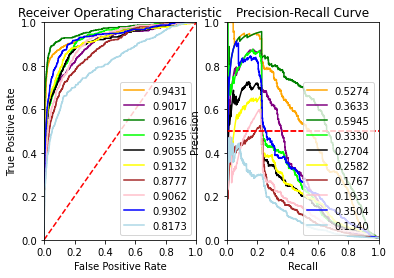

Average AUC score =  0.908005119707916
Average AUPRC score =  0.32011027585495155
Average f1 score =  0.39140281509029773
Average recall =  0.34430894308943094
Average precision =  0.497861794223298
Average accuracy =  0.9911080115072792
[{'AUC': 0.015382229073787368, 'PRC': 0.04953672993846905}, {'AUC': 0.028539194922753145, 'PRC': 0.1096391553253704}, {'AUC': 0.024556987394023944, 'PRC': 0.058608382551678356}, {'AUC': 0.017683931294326882, 'PRC': 0.10150350149222688}, {'AUC': 0.007759917849959039, 'PRC': 0.10725096096724382}, {'AUC': 0.009976221613714534, 'PRC': 0.06436962118348827}, {'AUC': 0.0022138007100906557, 'PRC': 0.01253237690625133}, {'AUC': 0.010696993983095416, 'PRC': 0.09815676826387322}, {'AUC': 0.006783863840546434, 'PRC': 0.03551769952219264}, {'AUC': 0.009104388239900597, 'PRC': 0.03762409646987352}]


In [11]:
rcParams['figure.figsize'] = 20, 5
#plot
fig, ax=plt.subplots(1,2)
proportion_of_abn = 0.5

colors = ['orange','purple','green','lime','black','yellow','brown','pink','blue','lightblue']
print(proportion_of_abn)


for i in range(len(TPR_res)):
    tpr, fpr = TPR_res[i], FPR_res[i]
    precision, recall = P_res[i], R_res[i]
    auc_score, auprc_score = AUC_res[i], AUPRC_res[i]
    indicator = colors[i]

    #ROC curve
    ax[0].plot(fpr, tpr, color = indicator, label = '%0.4f' % auc_score)
    ax[0].legend(loc = 'lower right')

    #PR curve
    ax[1].plot(recall, precision, color = indicator, label='%0.4f' % auprc_score)
    ax[1].legend(loc = 'lower right')
    


ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].set_title('Precision-Recall Curve')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')
plt.show()

#calculate average AUC and AUPRC score
print('Average AUC score = ',sum(AUC_res) / TOTAL_RUN)
print('Average AUPRC score = ',sum(AUPRC_res) / TOTAL_RUN)
print('Average f1 score = ',sum(fscore_res) / TOTAL_RUN)
print('Average recall = ',sum(recall_res) / TOTAL_RUN)
print('Average precision = ',sum(precision_res) / TOTAL_RUN)
print('Average accuracy = ', sum(accuracies)/TOTAL_RUN)

print(THR_opt)

#print optnimal thresholds of 10 folds
#print(THR_opt)

In [12]:
TPR_maxlen = FPR_maxlen = P_maxlen = R_maxlen = 0

for i in range(len(TPR_res)):
    if TPR_maxlen < len(TPR_res[i]): TPR_maxlen = len(TPR_res[i])
    if FPR_maxlen < len(FPR_res[i]): FPR_maxlen = len(FPR_res[i])
    if P_maxlen < len(P_res[i]): P_maxlen = len(P_res[i])
    if R_maxlen < len(R_res[i]): R_maxlen = len(R_res[i])

def AddOn(addTo,data,row, dataLen):
    tmp = data[0]
    for i in range(dataLen):
        if i<len(data[row]) and data[row][i] is not np.nan: tmp = data[row][i]
        addTo[i]+=tmp

def AVG(data):
    return (data / TOTAL_RUN).tolist()
TPR_avg, FPR_avg, P_avg, R_avg = np.zeros((TPR_maxlen)), np.zeros((FPR_maxlen)), np.zeros((P_maxlen)), np.zeros((R_maxlen))

for i in range(len(TPR_res)):
    AddOn(TPR_avg, TPR_res, i, TPR_maxlen)
    AddOn(FPR_avg, FPR_res, i, FPR_maxlen)
    AddOn(P_avg, P_res, i, P_maxlen)
    AddOn(R_avg, R_res, i, R_maxlen)
    
TPR_avg, FPR_avg, P_avg, R_avg = AVG(TPR_avg), AVG(FPR_avg), AVG(P_avg), AVG(R_avg)

# Save Result to json

In [13]:
import json

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), "r", encoding='utf-8') as jsonFile:
    data = json.load(jsonFile)

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), 'w', encoding='utf-8') as jsonFile:
    data['GAN-AE'] = {
            'AUC': AUC_res,
            'AUPRC': AUPRC_res,
            'Fscore': fscore_res,
            'Recall': recall_res,
            'Precision': precision_res,
            'Accuracy': accuracies,
            'THR_opt': THR_opt,
            'AVG': {
                'TPR': TPR_avg,
                'FPR': FPR_avg,
                'P': P_avg,
                'R': R_avg
            }
        }
    
    json.dump(data, jsonFile, ensure_ascii=False)

# End of Jupyter
* [To top](#common-link)